In [1]:
from typing import Dict, Tuple
from mpi4py import MPI
import numpy as np
from dataclasses import dataclass
import random as rnd
from repast4py import core, random, space, schedule, logging, parameters
from repast4py import context as ctx
import repast4py
from repast4py.space import DiscretePoint as dpt


In [2]:
@dataclass
class DiseaseLog:
    Infected: int = 0
    Recovered: int = 0

In [3]:
# Parameters
DURATION = (80, 100)
RECOVERPROB = 0.05
model = None
class Human(core.Agent):
    TYPE = 0
    def __init__(self, local_id: int, rank: int, pt: dpt, disease_prob: float, layer:int, number:int):
        super().__init__(id=local_id, type=Human.TYPE, rank=rank)
        self.pt = pt
        self.disease_prob = disease_prob
        self.clone = None
        self.infected = False
        self.infect_count = 0
        self.recover_count = 0
        self.infected_duration = 0
        self.layer = layer
        self.number = number
    
    def save(self) -> Tuple:
        """Saves the state of this Walker as a Tuple.

        Returns:
            The saved state of this Walker.
        """
        return (self.uid, self.pt.coordinates, self.disease_prob, self.infected, self.recovered,
                 self.infected_duration, self.layer, self.number, self.clone)
    
    def walk(self, grid, dist = 1):
        # choose two elements from the OFFSET array
        # to select the direction to walk in the
        # x and y dimensions
        #xy_dirs = random.default_rng.choice([-1,1], size=2)
        xy_dirs = [rnd.randint(-dist, dist), rnd.randint(-dist, dist)]
        self.pt = grid.move(self, dpt(self.pt.x + xy_dirs[0], self.pt.y + xy_dirs[1], 0))

    def infect(self):
        self.infected = True
        self.infect_count += 1
        self.infected_duration = rnd.randint(DURATION[0], DURATION[1])

    def recover(self):
        self.infected = False
        self.recover_count += 1
        self.disease_prob = RECOVERPROB

    def sync(self):
        self.clone.infected = self.infected
        self.clone.infect_count = self.infect_count
        self.clone.recovered = self.recover_count
        self.clone.infected_duration = self.infected_duration
        self.clone.disease_prob = self.disease_prob
        self.clone.recover_count = self.recover_count

    def spread_step(self, grid):
        if self.infected:
            self.infected_duration -= 1
            if self.infected_duration == 0:
                self.recover()
        else:
            for agent in grid.get_agents(self.pt):
                if agent.uid != self.uid:
                    rng = np.random.default_rng()
                    if agent.infected and rng.uniform() <= self.disease_prob:
                        self.infect()
                        break
        self.sync()
         


In [4]:
agent_cache = {}

def restore_human(agent_data: Tuple):
    """
    Args:
        agent_data: tuple containing the data returned by Human.save.
    """
    # uid is a 3 element tuple: 0 is id, 1 is type, 2 is rank
    uid = agent_data[0]
    pt_array = agent_data[2]
    pt = dpt(pt_array[0], pt_array[1], 0)

    # Check if the agent already exists in the cache
    if uid in agent_cache:
        agent = agent_cache[uid]
    else:
        # Create a new Human agent if not found in the cache
        agent = Human(uid[0], uid[2], pt, agent_data[3], agent_data[4], agent_data[5])
        agent_cache[uid] = agent

    # Restore the agent's state
    agent.infected = agent_data[6]
    agent.recovered = agent_data[7]
    agent.infected_duration = agent_data[8]
    agent.pt = pt

    return agent

In [5]:
class Model:
    def __init__(self, comm: MPI.Intracomm, params: Dict):
        self.runner = schedule.init_schedule_runner(comm)
        self.runner.schedule_repeating_event(1, 7, self.step1)
        self.runner.schedule_repeating_event(2, 7, self.step1)
        self.runner.schedule_repeating_event(3, 7, self.step1)
        self.runner.schedule_repeating_event(4, 7, self.step1)
        self.runner.schedule_repeating_event(5, 7, self.step1)
        self.runner.schedule_repeating_event(6, 7, self.step2)
        self.runner.schedule_repeating_event(7, 7, self.step2)
        self.runner.schedule_repeating_event(1.1, 1, self.log_agents)
        self.runner.schedule_stop(params['stop.at'])
        self.runner.schedule_end_event(self.at_end)

        self.context = ctx.SharedContext(comm)

        box = space.BoundingBox(0, params['world.width'], 0, params['world.height'], 0, 0)
        box1 = space.BoundingBox(0, params['world.width'] // 2, 0, params['world.height'] // 2, 0, 0)
        # create a SharedGrid of 'box' size with sticky borders that allows multiple agents
        # in each grid location.
        self.grid = space.SharedGrid(name='grid', bounds=box, borders=space.BorderType.Sticky,
                                     occupancy=space.OccupancyType.Multiple, buffer_size=2, comm=comm)
        self.context.add_projection(self.grid)
        self.grid1 = space.SharedGrid(name='grid1', bounds=box1, borders=space.BorderType.Sticky,
                                     occupancy=space.OccupancyType.Multiple, buffer_size=2, comm=comm)
        self.context.add_projection(self.grid1)

        self.layer1 = set()
        self.layer2 = set()
        self.dist = params['distance']
        rank = comm.Get_rank()
        rng = repast4py.random.default_rng

        for i in range(params['walker.count']):
            # Layer 1 agent creation
            pt1 = self.grid.get_random_local_pt(rng)
            human1 = Human(i, rank, pt1, params['disease_prob'],layer=1, number=i)
            self.context.add(human1)
            self.layer1.add(human1)
            self.grid.move(human1, pt1)

            # Layer 2 agent creation (the clone)
            pt2 = self.grid1.get_random_local_pt(rng)
            human2 = Human(params['walker.count'] + i, rank, pt2, params['disease_prob'], layer=2, number=i)
            self.context.add(human2)
            self.layer2.add(human2)
            self.grid1.move(human2, pt2)

            # Assign clones (human1 is the clone of human2 and vice versa)
            human1.clone = human2
            human2.clone = human1
            if i <= params['initial_seed']:
                human1.infect()
                human1.sync()

        

        # initialize the logging
        self.agent_logger = logging.TabularLogger(
            comm, 
            params['log_file'], 
            ['Tick', 'Current Infected', 'Cumulative Infected', 'Cumulative Recovered']
        )

        self.disease_log = DiseaseLog()

    def step1(self):
        for agent in self.layer1:
            #if agent.infected == False:
                agent.walk(self.grid)

        self.context.synchronize(restore_human)

        for agent in self.layer1:
            agent.spread_step(self.grid)
    
    def step2(self):
        for agent in self.layer2:
            if agent.infected == False:
                agent.walk(self.grid1, self.dist)

        self.context.synchronize(restore_human)

        for agent in self.layer2:
            agent.spread_step(self.grid1)

    def log_agents(self):
        tick = self.runner.schedule.tick
        current_infected = sum(1 for agent in self.context.agents() if agent.infected) // 2
        cumulative_recovered = sum(agent.recover_count for agent in self.context.agents()) // 2
        cumulative_infected = sum(agent.infect_count for agent in self.context.agents()) // 2
        self.agent_logger.log_row([tick, current_infected, cumulative_infected, cumulative_recovered])
        self.agent_logger.write()
    
    def at_end(self):
        self.agent_logger.close()

    def start(self):
        self.runner.execute()
    
    def reset(self):
        # Remove all agents from the context
        for agent in list(self.context.agents()):
            self.context.remove(agent)

        # Clear agent sets
        self.layer1.clear()
        self.layer2.clear()
    

In [6]:
NUM_RUN = 100
def run(params: Dict = None):
    global model
    if params is None:
        params = {}

    # Default values
    
    defaults = {
        # Model params
        random.seed: 42,
        'initial_seed' : 100,
        'walker.count': 1000,
        'disease_prob' : 0.5,
        'stop.at': 500,
        'distance' : 4,
        'world.width': 200,
        'world.height': 200,
        'log_file': 'output_quaratine_weekend/disease_log.csv'
    }

    # Update defaults with provided params
    combined_params = {**defaults, **params}

    model = Model(MPI.COMM_WORLD, combined_params)
    model.start()

def reset():
    model.reset()
    
if __name__ == "__main__":
    for i in range(NUM_RUN):
        run()
        reset()

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import numpy as np

# Function to load and process data from a directory
def load_and_average_csvs(directory):
    # Get a list of all CSV files in the directory
    csv_files = glob.glob(f'{directory}/disease_log_*.csv')
    
    # Initialize a list to store dataframes
    dfs = []
    
    for file in csv_files:
        # Load the CSV file
        data = pd.read_csv(file)
        # Clean and process the data (assuming 'Tick' is the first column and contains strings of tuples)
        data[['Tick', 'Current Infected', 'Cumulative Infected', 'Cumulative Recovered']] = data['Tick'].apply(lambda x: pd.Series(eval(x)))
        # Append the dataframe to the list
        dfs.append(data)
    
    # Concatenate all dataframes into one
    combined_data = pd.concat(dfs, axis=0)
    
    # Group by 'Tick' and calculate the mean for each column
    averaged_data = combined_data.groupby('Tick').mean().reset_index()
    
    return averaged_data


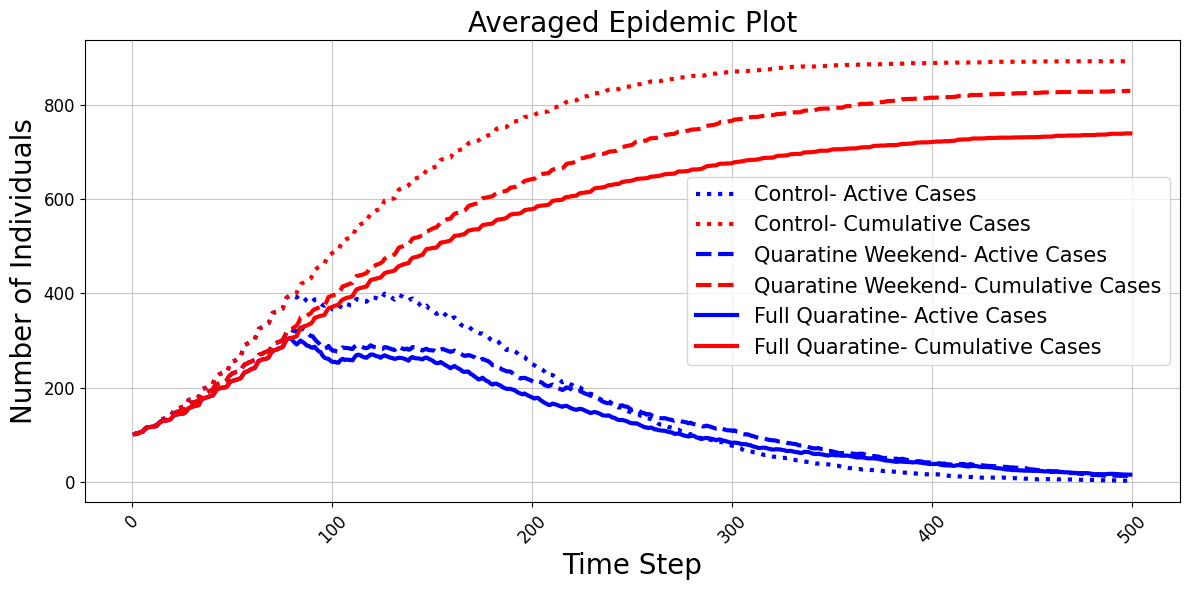

In [43]:
# Load and average CSVs from both directories
Control = load_and_average_csvs('output_no_quaratine')
Quaratine_Weekday = load_and_average_csvs('output_quaratine_weekday')
Quaratine_Weekend = load_and_average_csvs('output_quaratine_weekend')
Quaratine_Full = load_and_average_csvs('output_quaratine_full')


# Plotting
plt.figure(figsize=(12, 6))

# Plotting for Control Group
plt.plot(Control['Tick'], Control['Current Infected'], label='Control- Active Cases', color = 'blue', linestyle = ':', linewidth = 3)
plt.plot(Control['Tick'], Control['Cumulative Infected'], label='Control- Cumulative Cases', color = 'red', linestyle = ':', linewidth = 3)

# # Plotting for Quaratine on Weekdays
# plt.plot(Quaratine_Weekday['Tick'], Quaratine_Weekday['Current Infected'], label='Quaratine Weekday- Active Cases', color = 'blue', linestyle = '--', linewidth = 3)
# plt.plot(Quaratine_Weekday['Tick'], Quaratine_Weekday['Cumulative Infected'], label='Quaratine Weekday- Cumulative Cases', color = 'red', linestyle = '--', linewidth = 3)

# Plotting for Quaratine on Weekends
plt.plot(Quaratine_Weekend['Tick'], Quaratine_Weekend['Current Infected'], label='Quaratine Weekend- Active Cases', color = 'blue', linestyle = '--', linewidth = 3)
plt.plot(Quaratine_Weekend['Tick'], Quaratine_Weekend['Cumulative Infected'], label='Quaratine Weekend- Cumulative Cases', color = 'red', linestyle = '--', linewidth = 3)

# Plotting for Full Quaratine 
plt.plot(Quaratine_Full['Tick'], Quaratine_Full['Current Infected'], label='Full Quaratine- Active Cases', color = 'blue', linestyle = 'solid',linewidth = 3)
plt.plot(Quaratine_Full['Tick'], Quaratine_Full['Cumulative Infected'], label='Full Quaratine- Cumulative Cases', color = 'red', linestyle = 'solid',linewidth = 3)


# Adding labels and title
plt.title('Averaged Epidemic Plot', fontsize=20)
plt.xlabel('Time Step', fontsize=20)
plt.ylabel('Number of Individuals', fontsize=20)
plt.legend(fontsize = 15)
plt.grid(True, alpha=0.7)
plt.xticks(rotation=45,fontsize = 12 )
plt.yticks(fontsize = 12 )
plt.tight_layout()

# Show the plot
plt.show()
